# **Step 1:** Training a <nobr>Micro$\mathbb{S}$plit</nobr> Model

# Introduction - what does this notebook do?

Below, we will train a <nobr>Micro$\mathbb{S}$plit</nobr> network for unmixing two superimposed channels for a custom dataset you provide. 

<div class="alert alert-block alert-info">
<b>Important:</b> How to organize your data for training a <nobr>Micro$\mathbb{S}$plit</nobr> model
</div>

Below, we will train a <nobr>Micro$\mathbb{S}$plit</nobr> network for unmixing two superimposed channels for a custom dataset you provide. 

You should organize you dataset as follows:
- Create a `data` directory
- Create subdirectories `channel_1` and `channel_2` containing the channels you would like to unmix
- Make sure that the images have the same spatial size and each image has only 1 channel

Your data directory should look like this:
```
you_data_path/
└── data
    ├── channel_1
    │   ├── image1.tiff
    │   ├── image2.tiff
    │   └── image3.tiff
    └── channel_2
        ├── image1.tiff
        ├── image2.tiff
        └── image3.tiff
```

The mixed image used for splitting will be obtained artificially by a convex combination of the target channels.

Let's begin!

## Background: what is <nobr>Micro$\mathbb{S}$plit</nobr> training all about?
Training is done in a supervised way. For every input patch, we have the two corresponding target patches using which we train our MicroSplit. 
Besides the primary input patch, we also feed LC inputs to MicroSplit. We introduced LC inputs in [μSplit: efficient image decomposition for microscopy data](https://openaccess.thecvf.com/content/ICCV2023/papers/Ashesh_uSplit_Image_Decomposition_for_Fluorescence_Microscopy_ICCV_2023_paper.pdf), which enabled the network to understand the global spatial context around the input patch.

To enable unsupervised denoising, we integrated the KL loss formulation and Noise models from our previous work [denoiSplit: a method for joint microscopy image splitting and unsupervised denoising](https://eccv.ecva.net/virtual/2024/poster/2538). 

The loss function for MicroSplit is a weighted average of denoiSplit loss and μSplit loss. For both denoiSplit and μSplit, their loss expression have two terms: KL divergence loss and likelihood loss. For more details, please refer to the respective papers.

# Let's do it, let's train a <nobr>Micro$\mathbb{S}$plit</nobr> Model!

**You are new to Jupyter notebooks?** Don't worry, if you take the time to read all our explanations, we will guide you through them and you will understand a lot. Still, you will likely end up less frustrated, if you do not even start with the ambition to interpret the purpose of every line of code.
Let's start with a nice example, the imports to enable the remainder of this notebook. Ignore it (unless you know what you are doing) and just click **⇧*Shift* + ⏎*Enter*** to execute this (and all other) code cells. 

In [1]:
# importing all the things we need further down
from pathlib import Path

import pooch
import matplotlib.pyplot as plt
from careamics.lightning import VAEModule
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader

from microsplit_reproducibility.configs.factory import (
    create_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.utils.callbacks import get_callbacks
from microsplit_reproducibility.utils.io import load_checkpoint_path
from microsplit_reproducibility.datasets import create_train_val_datasets
from microsplit_reproducibility.utils.utils import plot_input_patches

# Dataset specific imports...
from microsplit_reproducibility.configs.parameters.custom_dataset import (
    get_microsplit_parameters,
)
from microsplit_reproducibility.configs.data.custom_dataset import get_data_configs
from microsplit_reproducibility.datasets.custom_dataset import get_train_val_data

# **Step 1.1:** Data Preparation

Since the channel unmixing capabilities of <nobr>Micro$\mathbb{S}$plit</nobr> are trained in a supervised way, we must later feed *(i)* input images that contain both selected structures, and *(ii)* two seperate channels that show these two structures separately. As previosuly mentioned, the mixed input image is obtained synthetically by overlapping the other two channels.

### Load example data

In [2]:
DATA = pooch.create(
    path=f"./data/",
    base_url=f"https://download.fht.org/jug/msplit/ht_lif24/data_tiff/",
    registry={f"ht_lif24_5ms_reduced.zip": None},
)
for fname in DATA.registry:
    DATA.fetch(fname, processor=pooch.Unzip(), progressbar=True)

DATA_PATH = DATA.abspath / (DATA.registry_files[0] + ".unzip/5ms/data/")

### OR set the path to your own data
Important: the path should end with `data/`

In [3]:
DATA_PATH = Path("/my/path/data")

### Setup the path to the noise models
This is the path to the noise models that you trained in the notebook **00_noisemodels.ipynb**

In [3]:
NM_PATH = Path("./noise_models/")

### Next, we load the image data to be processed

Note that depending on the amount of GPU memory you have available, you might want to adjust the batch size. The default is 32, but you can reduce it to 16 if you run out of memory by changing the <i> batch_size </i> parameter in <i> get_microsplit_parameters </i> below.


In [4]:
# setting up train, validation, and test data configs
train_data_config, val_data_config, test_data_config = get_data_configs(
    image_size=(64, 64), num_channels=2
)

# setting up MicroSplit parametrization
experiment_params = get_microsplit_parameters(
    img_size=(64, 64),
    batch_size=32,
    num_epochs=10,
    multiscale_count=3,
    noise_model_path=NM_PATH,
    target_channels=2,
)

# create the dataset
train_dset, val_dset, _, data_stats = create_train_val_datasets(
    datapath=DATA_PATH,
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=val_data_config,
    load_data_func=get_train_val_data,
)

(20, 1608, 1608, 2)

Padding is not used with this alignement style
(20, 1608, 1608, 2)

Padding is not used with this alignement style
(20, 1608, 1608, 2)

Padding is not used with this alignement style


***Optional:*** inspect data configurations and <nobr>Micro$\mathbb{S}$plit</nobr> config

In [5]:
do_show_configs = True

if do_show_configs:
    print("FYI: train_data_config")
    print("----------------------")
    for cfg in train_data_config:
        print(cfg)

    print("\nFYI: experiment_params")
    print("----------------------")
    print(experiment_params)
else:
    print("You opted out of having all params printed... swiftly moving on... ;)")

FYI: train_data_config
----------------------
('data_type', <DataType.HTLIF24Data: 1>)
('depth3D', 1)
('datasplit_type', <DataSplitType.Train: 1>)
('num_channels', 2)
('ch1_fname', None)
('ch2_fname', None)
('ch_input_fname', None)
('input_is_sum', False)
('input_idx', None)
('target_idx_list', None)
('start_alpha', [0.1, 0.1])
('end_alpha', [0.9, 0.9])
('image_size', (64, 64))
('grid_size', 32)
('empty_patch_replacement_enabled', False)
('empty_patch_replacement_channel_idx', None)
('empty_patch_replacement_probab', None)
('empty_patch_max_val_threshold', None)
('uncorrelated_channels', False)
('uncorrelated_channel_probab', 0.5)
('poisson_noise_factor', -1.0)
('synthetic_gaussian_scale', 100.0)
('input_has_dependant_noise', True)
('enable_gaussian_noise', False)
('allow_generation', False)
('training_validtarget_fraction', None)
('deterministic_grid', None)
('enable_rotation_aug', False)
('max_val', None)
('overlapping_padding_kwargs', {'mode': 'reflect'})
('print_vars', False)
('nor

### Final step: create Dataloaders for network training

In [6]:
train_dset._data.shape

(16, 1608, 1608, 2)

In [7]:
train_dloader = DataLoader(
    train_dset,
    batch_size=experiment_params["batch_size"],
    num_workers=experiment_params["num_workers"],
    shuffle=True,
)
val_dloader = DataLoader(
    val_dset,
    batch_size=experiment_params["batch_size"],
    num_workers=experiment_params["num_workers"],
    shuffle=False,
)

# **Step 1.2:** Prepare <nobr>Micro$\mathbb{S}$plit</nobr> Training
Next, we create all the configs for the upcoming network training run. These lines are not very intuitive and if you don't intend to dive really deep into CAREamics and the internals of <nobr>Micro$\mathbb{S}$plit</nobr>, you might just execute these cells and move on.

In [8]:
# making our data_stas known to the experiment we prepare
experiment_params["data_stats"] = data_stats

# setting up training losses and model config (using default parameters)
loss_config = get_loss_config(**experiment_params)
model_config = get_model_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)
training_config = get_training_config(**experiment_params)

# setting up learning rate scheduler and optimizer (using default parameters)
lr_scheduler_config = get_lr_scheduler_config(**experiment_params)
optimizer_config = get_optimizer_config(**experiment_params)

# finally, assemble the full set of experiment configurations...
experiment_config = create_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
    lr_scheduler_config=lr_scheduler_config,
    optimizer_config=optimizer_config,
)

## Initialize the <nobr>Micro$\mathbb{S}$plit</nobr> model to be trained..

In [9]:
model = VAEModule(algorithm_config=experiment_config)

[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5.0


## Show some training data for a final check!
***Tip:*** we show you a few samples of the prepared training data. In case you don't like what you see, execute the cell again and other randomly chosen patches will be shown!

[22140, 5560, 27111]

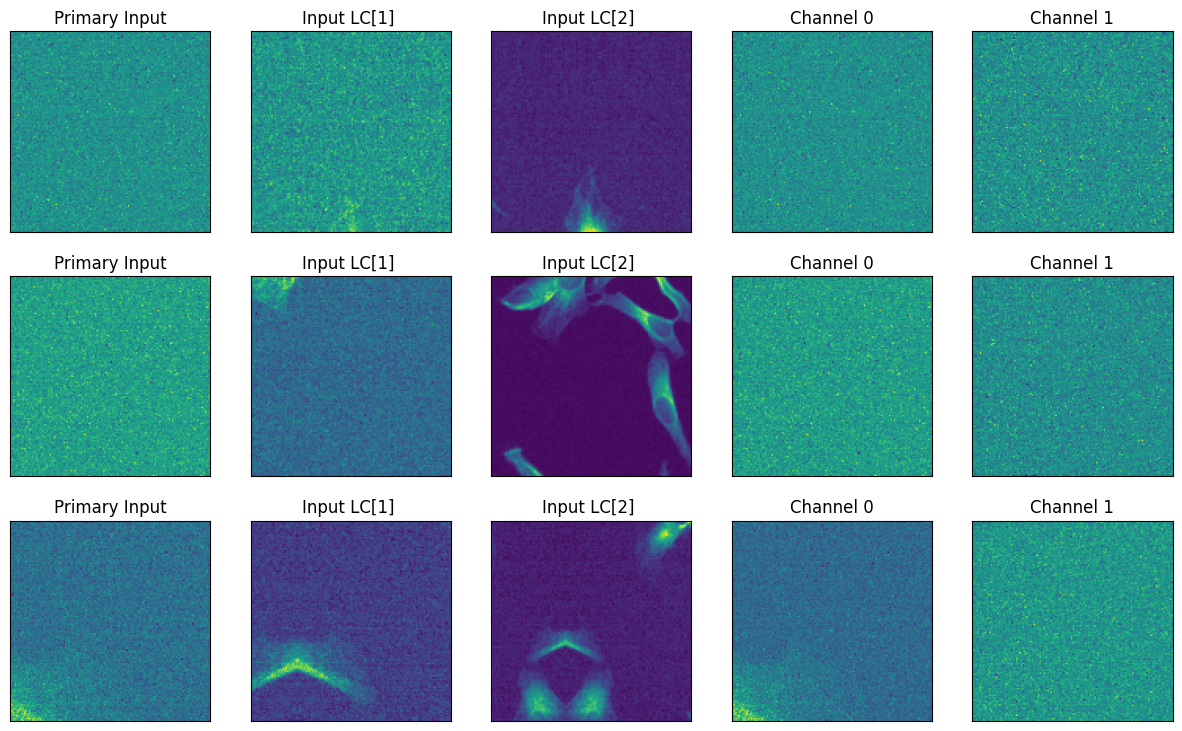

In [10]:
plot_input_patches(dataset=train_dset, num_channels=2, num_samples=3, patch_size=128)

# **Step 1.3:** Train the prepared model!
***Note:*** if this takes too long, there were to places above where we gave you options to *(i)* reduce the amount of training data, and *(ii)* chose to train for fewer epochs. Revisit your choices if you want to!

***Note:*** Depending on the amount of GPU memory you have available, you might want to adjust the batch size. The default is 32, but you can reduce it to 16 if you run out of memory by changing the <i> batch_size </i> parameter in <i> get_microsplit_parameters </i> above.


In [11]:
# create the Trainer
trainer = Trainer(
    max_epochs=1,
    accelerator="gpu",
    enable_progress_bar=True,
    callbacks=get_callbacks("./checkpoints/"),
    precision=training_config.precision,
    gradient_clip_val=training_config.gradient_clip_val,
    gradient_clip_algorithm=training_config.gradient_clip_algorithm,
)
# start the training
trainer.fit(
    model=model,
    train_dataloaders=train_dloader,
    val_dataloaders=val_dloader,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/localscratch/micromamba/envs/careamics/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | model               | LadderVAE          | 3.6 M  | train
1 | gaussian_likelihood | GaussianLikelihood | 0      | train
-------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.270    Total estimated model params size (MB)
317       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/localscratch/micromamba/envs/careamics/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


# **Step 1.4:** Predict and visualize results for validation data...

In [13]:
val_dset.reduce_data([0])

[LCMultiChDloader] Data reduced. New data shape: (1, 1608, 1608, 2)


In [14]:
from microsplit_reproducibility.notebook_utils.custom_test import (
    get_unnormalized_predictions,
    get_target,
    get_input,
)

stitched_predictions, _, _ = get_unnormalized_predictions(
    model, val_dset, mmse_count=1, num_workers=0, batch_size=8
)
tar = get_target(val_dset)

# get input as sum of the two channels
inp = get_input(val_dset).sum(-1)

Predicting tiles:   0%|          | 0/313 [00:00<?, ?it/s]/home/vera.galinova/dev/internal_repos/careamics/src/careamics/lvae_training/eval_utils.py:652: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /opt/conda/conda-bld/pytorch_1724789115370/work/aten/src/ATen/native/ReduceOps.cpp:1808.)
  std_imgs = torch.std(samples, dim=0)  # std over MMSE dim
Predicting tiles: 100%|██████████| 313/313 [00:13<00:00, 22.75it/s]


## Overview: visualize predictions on validation data...

Text(0.5, 1.0, 'Prediction ch2')

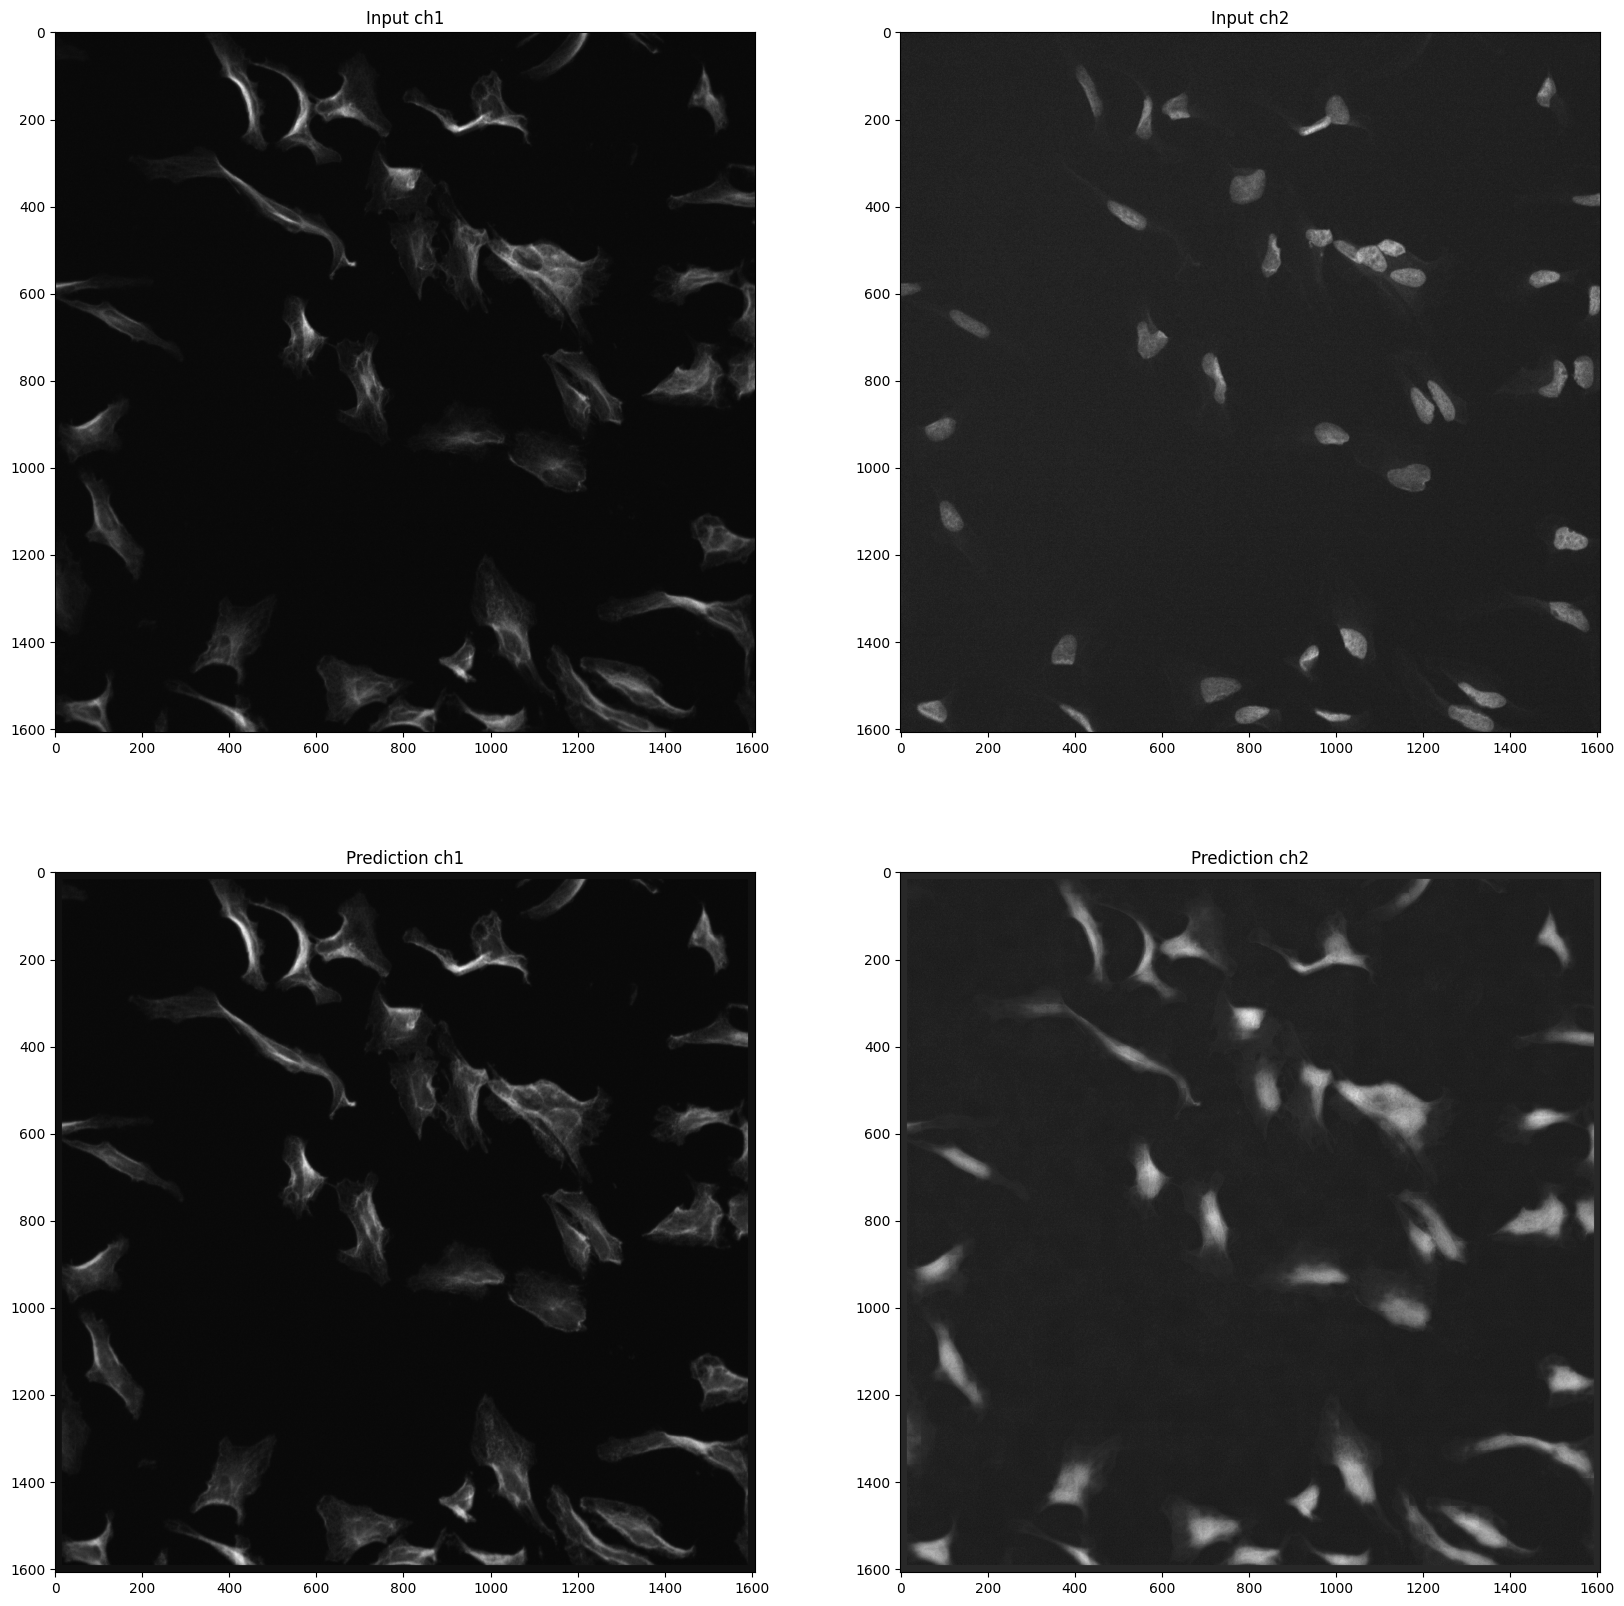

In [15]:
_, ax = plt.subplots(2, 2, figsize=(20, 20))
ax[0, 0].imshow(tar[0, ..., 0], cmap="gray")
ax[0, 0].set_title("Input ch1")
ax[0, 1].imshow(tar[0, ..., 1], cmap="gray")
ax[0, 1].set_title("Input ch2")
ax[1, 0].imshow(stitched_predictions[0, ..., 0], cmap="gray")
ax[1, 0].set_title("Prediction ch1")
ax[1, 1].imshow(stitched_predictions[0, ..., 1], cmap="gray")
ax[1, 1].set_title("Prediction ch2")

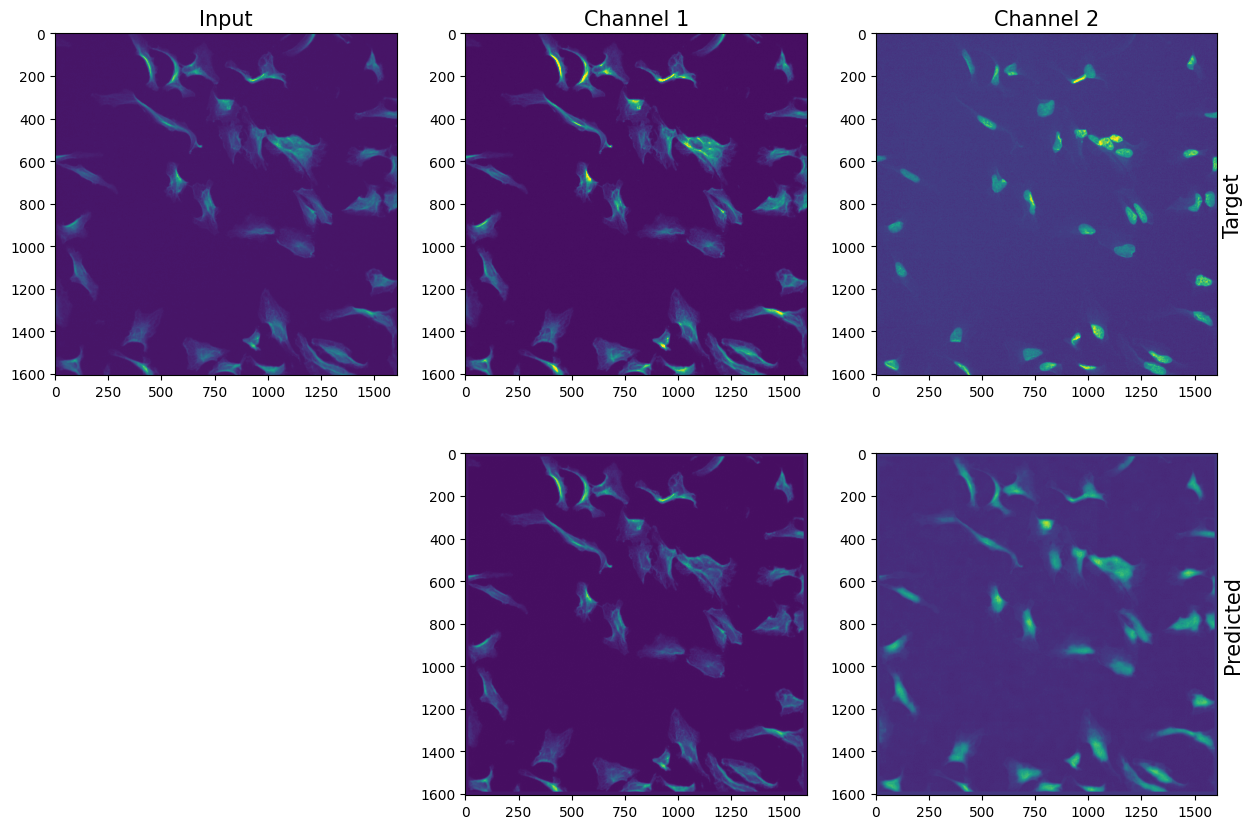

In [16]:
from microsplit_reproducibility.notebook_utils.custom_test import full_frame_evaluation

frame_idx = 0
assert frame_idx < len(stitched_predictions), f"Frame index {frame_idx} out of bounds"
full_frame_evaluation(stitched_predictions[frame_idx], tar[frame_idx], inp[frame_idx])

## Detailed view on some (foreground) locations...
Below, we show few random foreground locations and the corresponding <nobr>Micro$\mathbb{S}$plit</nobr> predictions.

As before, also here you can execute the cell multiple times and different randomly chosen locations will be plotted.

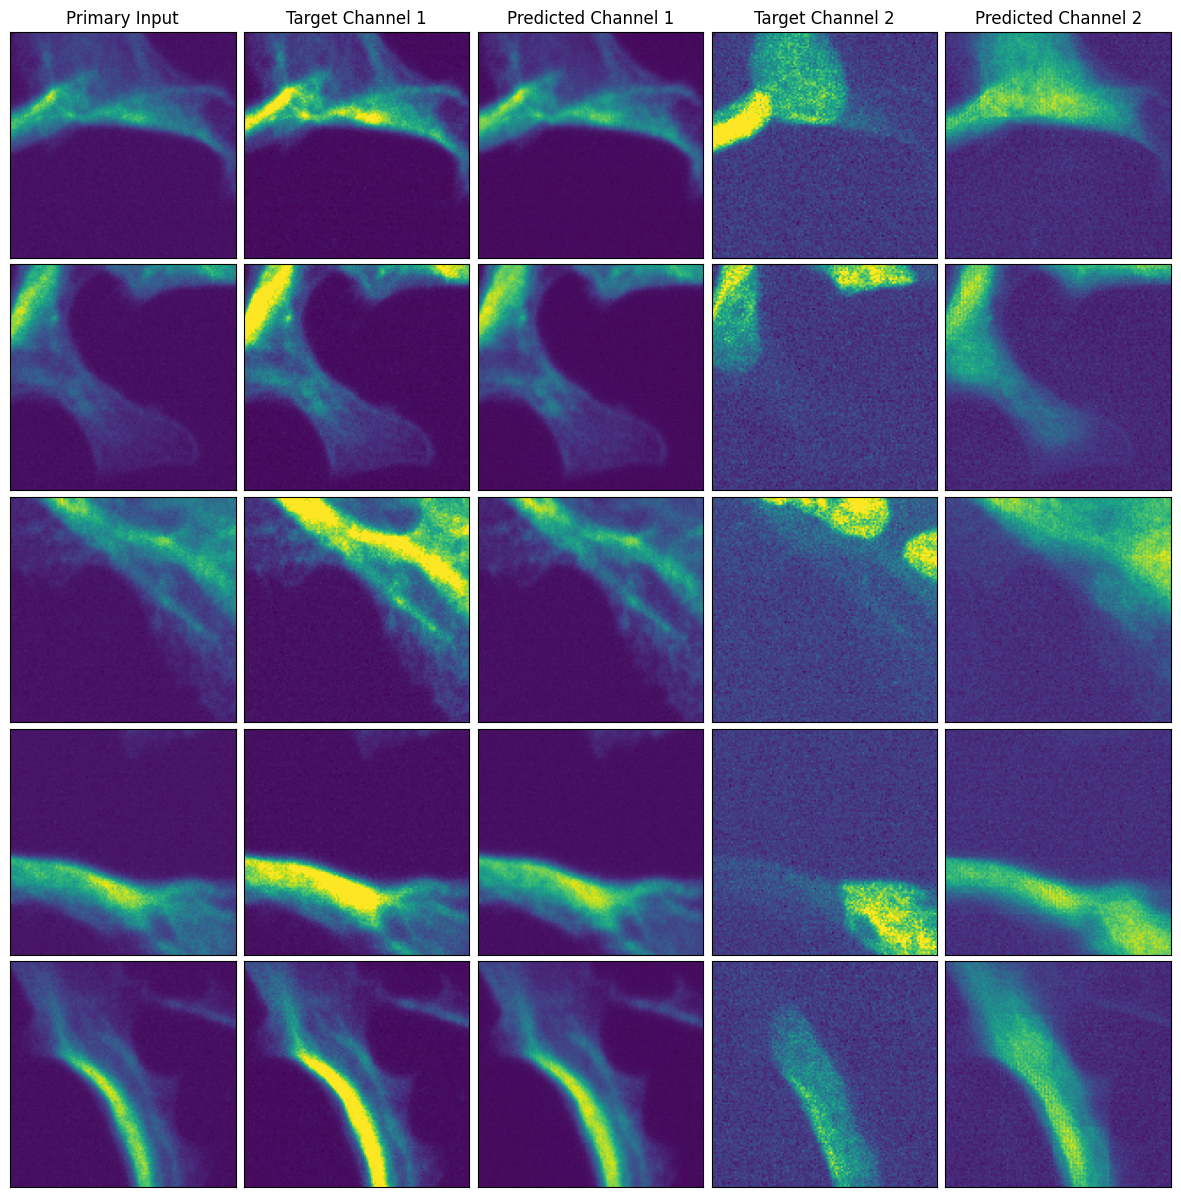

In [17]:
import numpy as np
from microsplit_reproducibility.utils.utils import clean_ax
from microsplit_reproducibility.notebook_utils.custom_test import (
    pick_random_patches_with_content,
)
import matplotlib.pyplot as plt

img_sz = 128
rand_locations = pick_random_patches_with_content(tar, 128)
h_start = rand_locations[
    2, 0
]  # np.random.randint(stitched_predictions.shape[1] - img_sz)
w_start = rand_locations[
    2, 1
]  # np.random.randint(stitched_predictions.shape[2] - img_sz)

ncols = 4 + 1
nrows = min(len(rand_locations), 5)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 3))

for i, (h_start, w_start) in enumerate(rand_locations[:nrows]):
    ax[i, 0].imshow(inp[0, h_start : h_start + img_sz, w_start : w_start + img_sz])
    for j in range(ncols // 2):
        vmin = stitched_predictions[
            0, h_start : h_start + img_sz, w_start : w_start + img_sz, j
        ].min()
        vmax = stitched_predictions[
            0, h_start : h_start + img_sz, w_start : w_start + img_sz, j
        ].max()
        ax[i, 2 * j + 1].imshow(
            tar[0, h_start : h_start + img_sz, w_start : w_start + img_sz, j],
            vmin=vmin,
            vmax=vmax,
        )
        ax[i, 2 * j + 2].imshow(
            stitched_predictions[
                0, h_start : h_start + img_sz, w_start : w_start + img_sz, j
            ],
            vmin=vmin,
            vmax=vmax,
        )

ax[0, 0].set_title("Primary Input")
for i in range(2):
    ax[0, 2 * i + 1].set_title(f"Target Channel {i+1}")
    ax[0, 2 * i + 2].set_title(f"Predicted Channel {i+1}")

# reduce the spacing between the subplots
plt.subplots_adjust(wspace=0.03, hspace=0.03)
clean_ax(ax)

## *Optional:* manual inspection of the predictions
<div class="alert alert-block alert-info">
<b> Task:</b> Set <i>y_start</i>, <i>x_start</i>, and <i>crop_size</i> to inspect the predictions at a  location of your choice.
</div>

Here the crop you selected:


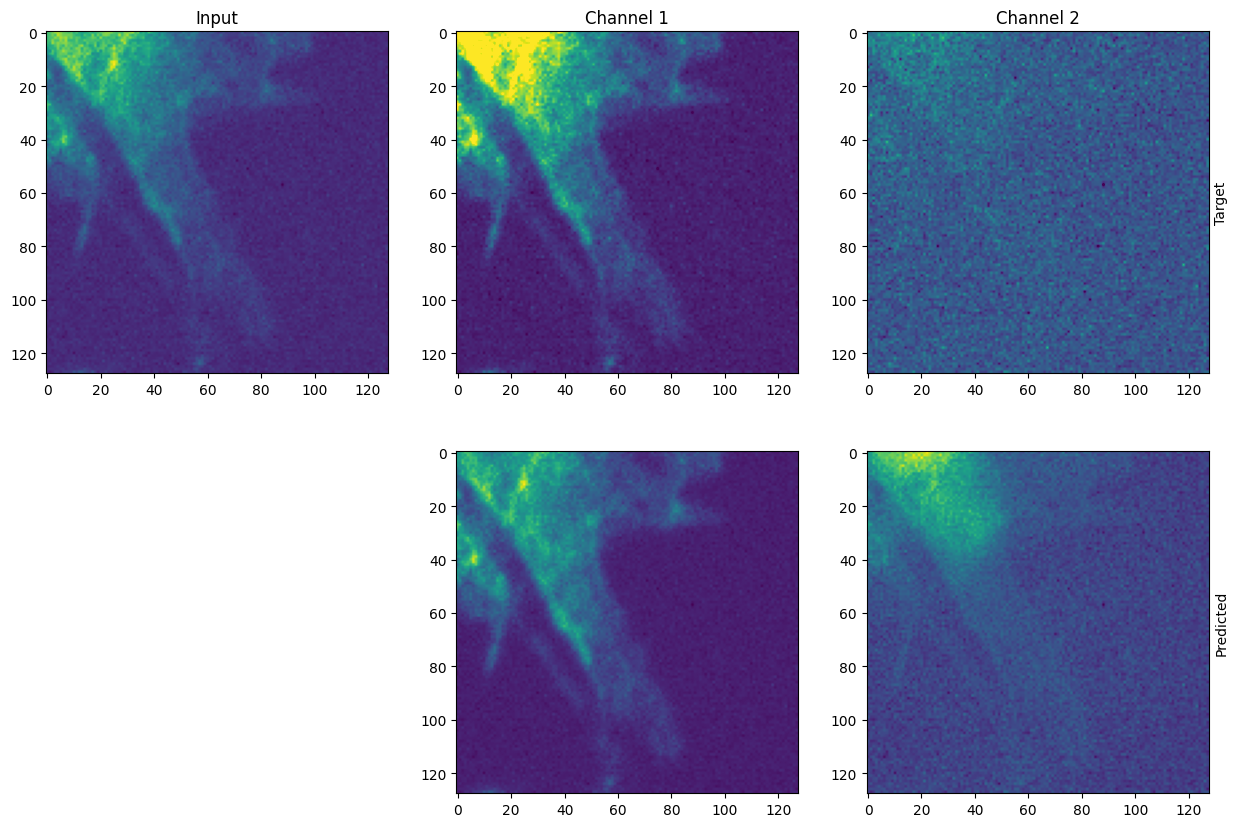

In [18]:
import numpy as np

y_start = 600  # np.random.randint(stitched_predictions.shape[1] - crop_size)
x_start = 1150  # np.random.randint(stitched_predictions.shape[2] - crop_size)
crop_size = 128

ncols = 3
nrows = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
ax[0, 0].imshow(inp[0, y_start : y_start + crop_size, x_start : x_start + crop_size])
for i in range(ncols - 1):
    vmin = stitched_predictions[
        0, y_start : y_start + crop_size, x_start : x_start + crop_size, i
    ].min()
    vmax = stitched_predictions[
        0, y_start : y_start + crop_size, x_start : x_start + crop_size, i
    ].max()
    ax[0, i + 1].imshow(
        tar[0, y_start : y_start + crop_size, x_start : x_start + crop_size, i],
        vmin=vmin,
        vmax=vmax,
    )
    ax[1, i + 1].imshow(
        stitched_predictions[
            0, y_start : y_start + crop_size, x_start : x_start + crop_size, i
        ],
        vmin=vmin,
        vmax=vmax,
    )

# disable the axis for ax[1,0]
ax[1, 0].axis("off")
ax[0, 0].set_title("Input")
ax[0, 1].set_title("Channel 1")
ax[0, 2].set_title("Channel 2")
# set y labels on the right for ax[0,2]
ax[0, 2].yaxis.set_label_position("right")
ax[0, 2].set_ylabel("Target")

ax[1, 2].yaxis.set_label_position("right")
ax[1, 2].set_ylabel("Predicted")

print("Here the crop you selected:")

# ***Optional Step 1.4:*** Posterior Sampling
For a given input patch, <nobr>Micro$\mathbb{S}$plit</nobr> can generate multiple outputs. This is possible because <nobr>Micro$\mathbb{S}$plit</nobr> is learning a full posterior of possible solutions, which is a quite powerful feature!

As we elaborate in the <nobr>Micro$\mathbb{S}$plit</nobr> paper and also later in the calibration notebook `03_calibration.ipynb`, this allows users to visually judge and even quantify the (data) uncertainty in the predictions their trained model makes.

Below, we show two posterior samples and how much they differ for a few random foreground locations. Re-run the cell to see different randomly choosen locations and corresponding posterior samples.

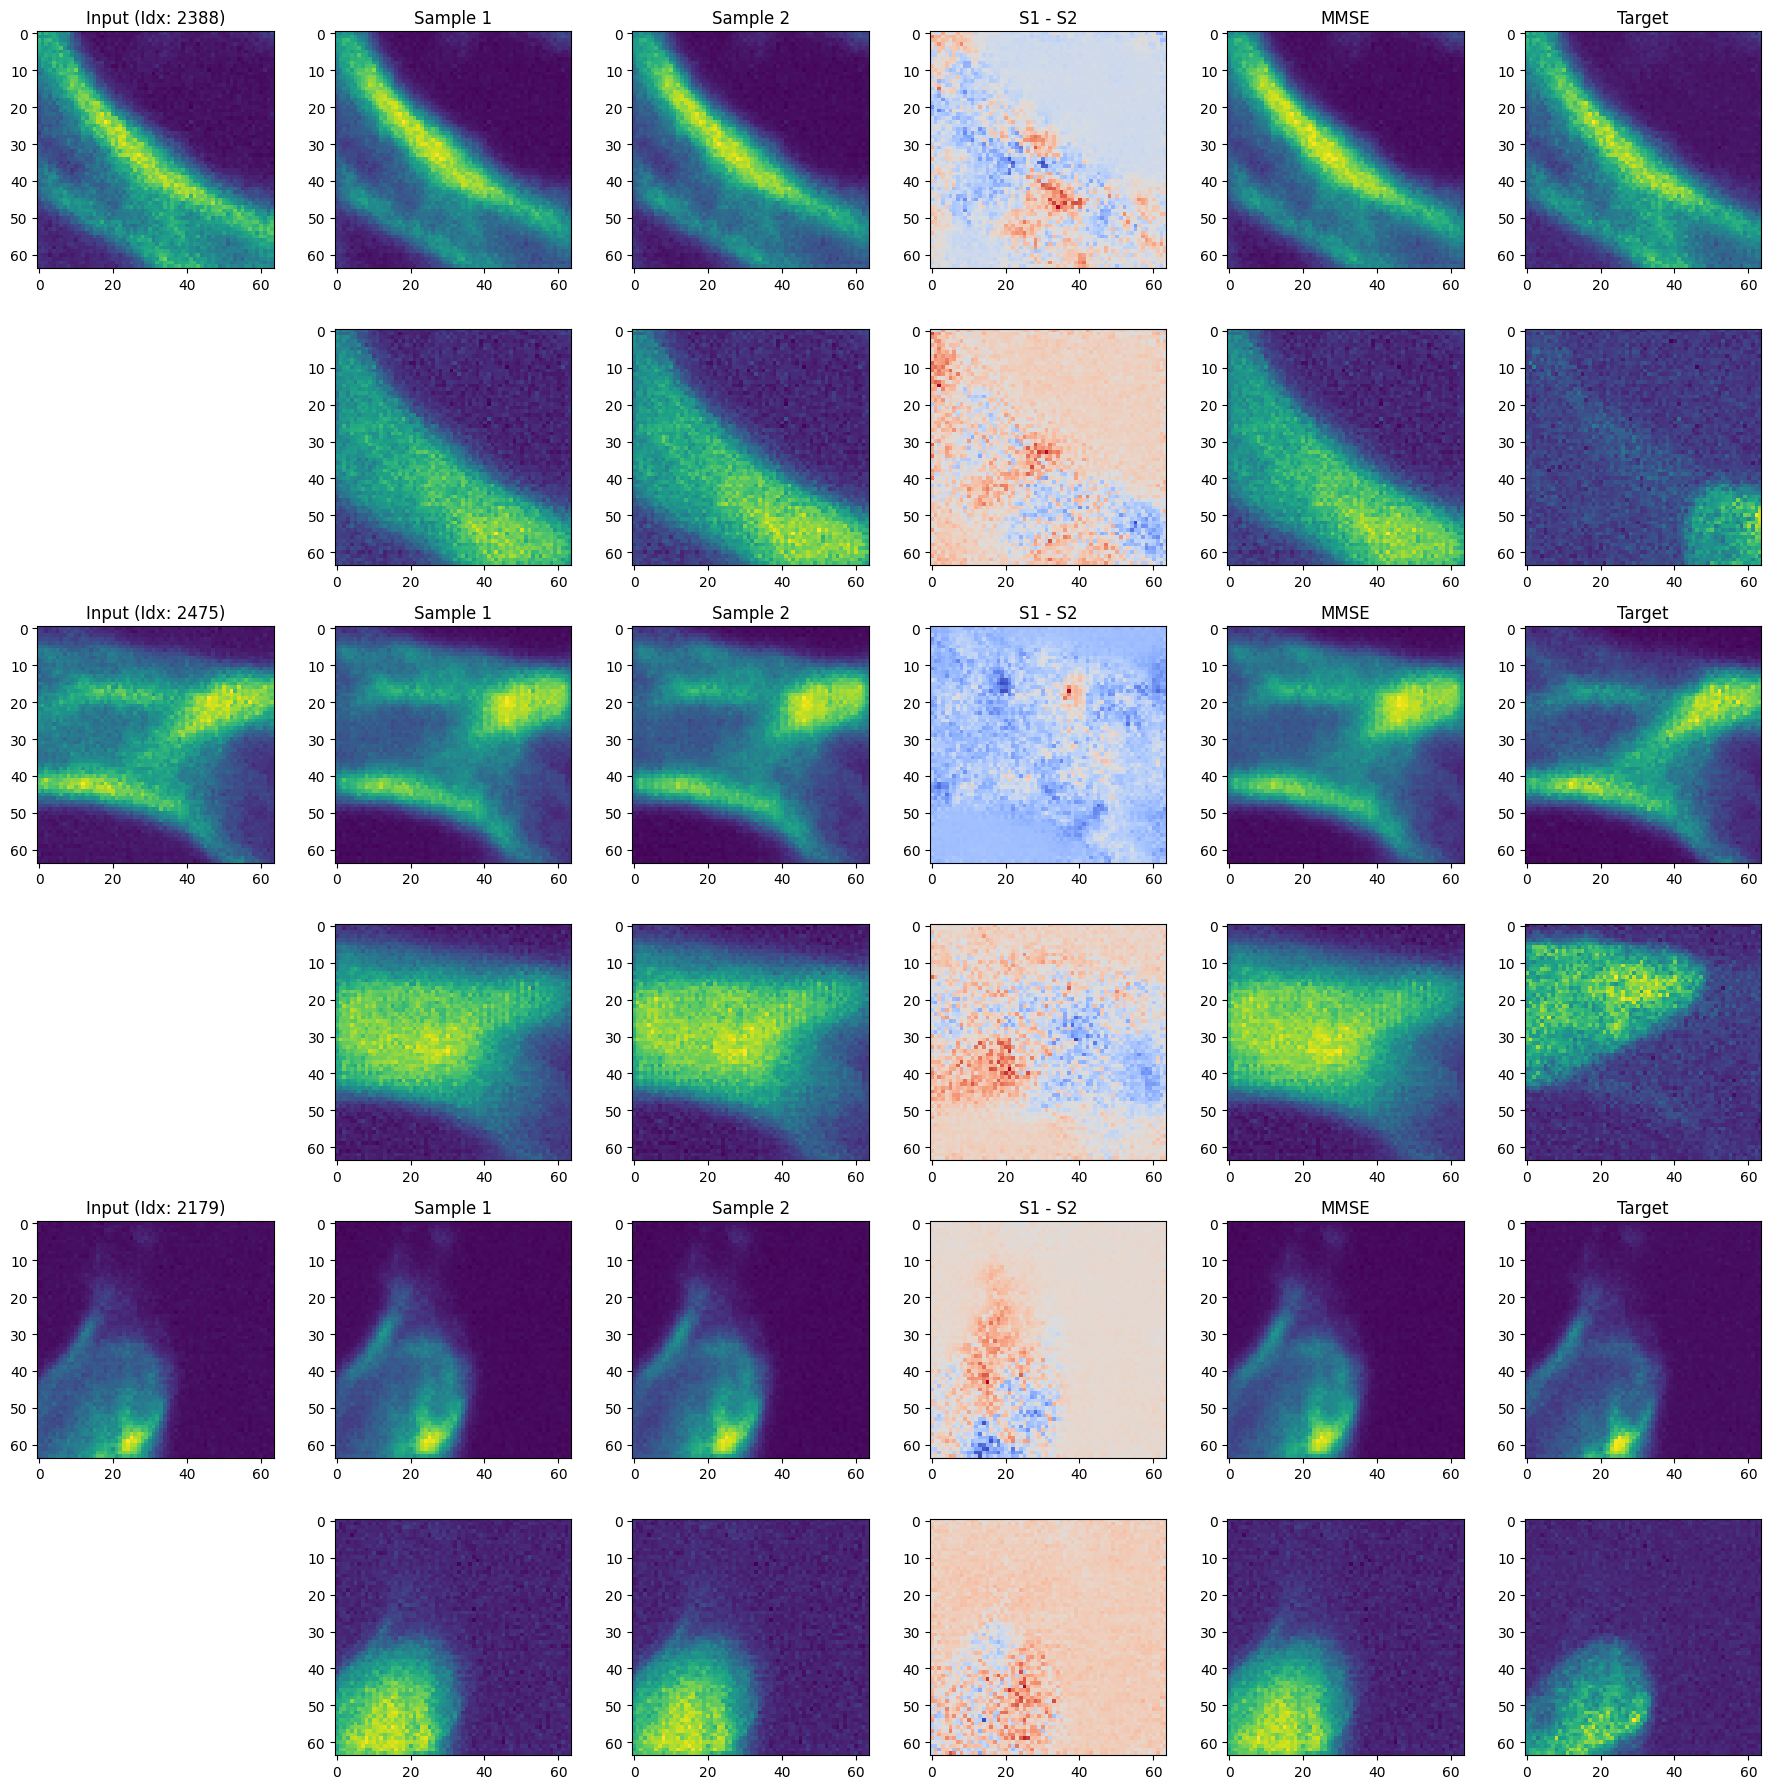

In [19]:
from microsplit_reproducibility.notebook_utils.custom_test import show_sampling

imgsz = 3
ncols = 6
examplecount = 3
_, ax = plt.subplots(
    figsize=(imgsz * ncols, imgsz * 2 * examplecount),
    ncols=ncols,
    nrows=2 * examplecount,
)

show_sampling(val_dset, model, ax=ax[:2])
show_sampling(val_dset, model, ax=ax[2:4])
show_sampling(val_dset, model, ax=ax[4:6])
plt.tight_layout()

### You are done here! 👍 Congratulations! 🎉